In [1]:
from keras import applications
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils.np_utils import to_categorical 
from keras.callbacks import ModelCheckpoint
from keras import Model
from keras import initializers
from keras.callbacks import LearningRateScheduler
from keras.utils import layer_utils, np_utils
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from classification_models import ResNet18
from classification_models.resnet import preprocess_input
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils import class_weight
import seaborn as sn
import pandas as pd
from scipy import interp
from itertools import cycle

Using TensorFlow backend.
c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
image_width = 224
image_height = 224

# Change the batchsize according to your system RAM
batch_size = 64

train_dir = "D:/retinal_data_set_visioncare/original_new"

resnet_base = ResNet18(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))

In [3]:
x = resnet_base.get_layer(index=-1).output
feature_extraction_layer = GlobalAveragePooling2D()(x)
model = Model(inputs=resnet_base.input, outputs=feature_extraction_layer)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

In [4]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_width, image_height),
        batch_size=batch_size,
        class_mode=None,  # this means our generator will only yield batches of data, no labels
        shuffle=False)

nb_train_samples = len(train_generator.filenames)  
num_classes = len(train_generator.class_indices)

# get the class lebels for the training data, in the original order  
train_labels = train_generator.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 927 images belonging to 5 classes.


In [5]:
# the predict_generator method returns the output of a model, given
# a generator that yields batches of numpy data
bottleneck_features_train = model.predict_generator(train_generator, nb_train_samples // batch_size + 1)
# save the output as a Numpy array
np.save(open('D:/retinal_data_set_visioncare/models/resnet18/bottle_neck_features/bottleneck_features_train_without_scikit_aug.npy', 'wb'), bottleneck_features_train)

In [6]:
model_check_point_loc = 'D:/retinal_data_set_visioncare/models/resnet18/resnet_small_without_aug_scikit_dr.h5'
model_checkpoint = ModelCheckpoint(model_check_point_loc, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

In [7]:
train_data = np.load(open('D:/retinal_data_set_visioncare/models/resnet18/bottle_neck_features/bottleneck_features_train_without_scikit_aug.npy', 'rb'))
#test_data = np.load(open('D:/retinal_data_set_visioncare/models/resnet18/bottle_neck_features/bottleneck_features_test_without_aug.npy', 'rb'))

In [8]:
train_data_labels = train_generator.classes

In [9]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_data_labels, test_size = 0.2, random_state = 21)

In [10]:
# Feature Scaling - fature normalizing
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
len(X_train)

741

In [12]:
# # Singular-value decomposition
# U,s,VT = np.linalg.svd(X_train)
# # create m x n Sigma matrix
# Sigma = np.zeros((X_train.shape[0], X_train.shape[1]))
# # populate Sigma with n x n diagonal matrix
# Sigma[:X_train.shape[1], :X_train.shape[1]] = np.diag(s)

In [14]:
# eigen_values = Sigma.diagonal()
# tot = sum(eigen_values)

# var_exp = [(i / tot)*100 for i in sorted(eigen_values, reverse=True)]
# cum_var_exp = np.cumsum(var_exp)

In [13]:
# with plt.style.context('seaborn-whitegrid'):
#     plt.figure(figsize=(6, 4))

#     plt.bar(range(512), var_exp, alpha=0.5, align='center',
#             label='individual explained variance')
#     plt.step(range(512), cum_var_exp, where='mid',
#              label='cumulative explained variance')
#     plt.ylabel('Explained variance ratio')
#     plt.xlabel('Principal components')
#     plt.legend(loc='best')
#     plt.tight_layout()

In [33]:
# # select
# n_elements = 350
# Sigma = Sigma[:, :n_elements]
# VT = VT[:n_elements, :]
# # reconstruct
# B = U.dot(Sigma.dot(VT))
# print(B)
# # transform
# transformed_data = U.dot(Sigma)
# print(transformed_data)

In [12]:
#train_data_labels = train_generator.classes  

X = X_train
#X = transformed_data
#Y = train_data_labels
Y = y_train

In [13]:
len(Y)

741

In [14]:
np.unique(train_data_labels)

array([0, 1, 2, 3, 4])

In [15]:
class_weight = class_weight.compute_class_weight('balanced'
                                               ,np.unique(y_train)
                                               ,y_train)

In [16]:
dict(enumerate(class_weight))

{0: 0.3732997481108312,
 1: 1.4388349514563106,
 2: 1.235,
 3: 3.2217391304347824,
 4: 1.976}

In [17]:
class_weight_dic = dict(enumerate(class_weight))

In [18]:
# define 5-fold cross validation test harness
#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=25)
cvscores = []
trainScores = []
f1Score = []
num_k_folds = 5
fold_counter = 0
val_conmats = []
val_precisions = []
val_recalls = []
val_f_scores = []
input_dim = 512
#input_dim = 350

# cross_model = Sequential()
# cross_model.add(Dense(256, input_dim=input_dim, activation='relu', kernel_initializer=initializers.he_normal(seed=None), kernel_regularizer=regularizers.l2(0.001)))
# cross_model.add(Dropout(0.5))
# cross_model.add(Dense(5, kernel_initializer=initializers.he_normal(seed=None), activation='softmax'))
cross_model = Sequential()
cross_model.add(Dense(128, input_dim=input_dim, kernel_initializer=initializers.he_normal(seed=None), kernel_regularizer=regularizers.l2(0.001)))
cross_model.add(BatchNormalization())
cross_model.add(Activation('relu'))
cross_model.add(Dropout(0.8))
cross_model.add(Dense(5, kernel_initializer=initializers.he_normal(seed=None), kernel_regularizer=regularizers.l2(0.001), activity_regularizer=regularizers.l2(0.001)))
cross_model.add(BatchNormalization())
cross_model.add(Activation('softmax'))

cross_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [19]:
for train, test in kfold.split(X, Y):
    # Fit the model
    cross_model.fit(X[train], to_categorical(Y[train]), epochs=400, batch_size=batch_size, class_weight=class_weight_dic, verbose=0)
    
    y_train_pred = cross_model.predict(X[train])
    y_train_pred = np.argmax(y_train_pred, axis=1)
    
    y_validation_pred = cross_model.predict(X[test])
    y_validation_pred = np.argmax(y_validation_pred, axis=1)
    #y_validation_pred = np.argmax(y_validation_pred, axis=1)
    
    [precision, recall, f_score, _] = precision_recall_fscore_support(Y[test], y_validation_pred)
    #print("Validation k-fold #%d - precision: %f, recallL: %f, f-score: %f" % (fold_counter, precision, recall, f_score))
    
    conmat = confusion_matrix(Y[test], y_validation_pred)
    
    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f_scores.append(f_score)
    val_conmats.append(conmat)
    fold_counter = fold_counter + 1
    
    trainScores.append(accuracy_score(Y[train], y_train_pred))
    cvscores.append(accuracy_score(Y[test], y_validation_pred))
    
print("\nAveraging the 5-fold results:")
print("%s: %.2f%%" % ('AVG Train Acc ', np.mean(trainScores) * 100))
print("%s: %.2f%%" % ('AVG Validation Acc ', np.mean(cvscores) * 100))
print("Validation precision - mean: %f, stddev: %f" % (np.mean(val_precisions), np.std(val_precisions)))
print("Validation recall - mean: %f, stddev: %f" % (np.mean(val_recalls), np.std(val_recalls)))
print("Validation f-score - mean: %f, stddev: %f" % (np.mean(val_f_scores), np.std(val_f_scores)))
print("Confusion matrix:")
print (sum(val_conmats).astype(float) / fold_counter)


Averaging the 5-fold results:
AVG Train Acc : 99.97%
AVG Validation Acc : 86.61%
Validation precision - mean: 0.849091, stddev: 0.126681
Validation recall - mean: 0.823590, stddev: 0.162644
Validation f-score - mean: 0.825659, stddev: 0.126278
Confusion matrix:
[[37.16  1.64  0.9   0.    0.  ]
 [ 2.42  6.86  0.92  0.    0.1 ]
 [ 0.92  0.66 10.08  0.06  0.28]
 [ 0.    0.06  0.14  3.92  0.48]
 [ 0.    0.26  0.44  0.66  6.14]]


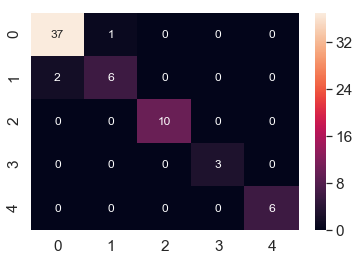

In [20]:
confusion_matrix_array = (sum(val_conmats).astype(float) / fold_counter)
new_confusion_matrix_array = []
for conf_sub_array in confusion_matrix_array:
    new_confusion_matrix_array.append([int(float(e)) for e in conf_sub_array])
        
df_cm = pd.DataFrame(new_confusion_matrix_array, range(5), range(5))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12})# font size

In [37]:
# Save the model
cross_model.save('D:/retinal_data_set_visioncare/models/resnet18/resnet_without_augmentation_scikit_model.h5')

In [21]:
#test_labels = test_generator.classes
test_labels = y_test

In [22]:
X_test.shape[0]

186

In [31]:
# # Singular-value decomposition
# U_test,s_test,VT_test = np.linalg.svd(X_test)
# # create m x n Sigma matrix
# Sigma_test = np.zeros((X_test.shape[0], X_test.shape[1]))
# # populate Sigma with n x n diagonal matrix
# Sigma_test[:X_test.shape[0], :X_test.shape[0]] = np.diag(s_test)

# # select
# n_elements_test = 350
# Sigma_test = Sigma_test[:, :n_elements_test]
# VT_test = VT_test[:n_elements_test, :]

# # transform
# transformed_data_test = U_test.dot(Sigma_test)

In [23]:
#Confution Matrix and Classification Report for testset
Y_pred_for_test = cross_model.predict(X_test)
Y_pred_for_test = np.argmax(Y_pred_for_test, axis=1)
print('Confusion Matrix for testset')
confusion_matrix_for_testset = confusion_matrix(test_labels, Y_pred_for_test)
print(confusion_matrix(test_labels, Y_pred_for_test))
print('Classification Report')
target_names = ['non-dr', 'mild-npdr', 'moderate-npdr', 'severe-npdr', 'pdr']
print(classification_report(test_labels, Y_pred_for_test, target_names=target_names))

Confusion Matrix for testset
[[85 13  3  0  0]
 [14  1  4  0  0]
 [ 0  6 20  3  0]
 [ 0  1  3 10  4]
 [ 0  0  1  7 11]]
Classification Report
               precision    recall  f1-score   support

       non-dr       0.86      0.84      0.85       101
    mild-npdr       0.05      0.05      0.05        19
moderate-npdr       0.65      0.69      0.67        29
  severe-npdr       0.50      0.56      0.53        18
          pdr       0.73      0.58      0.65        19

  avg / total       0.69      0.68      0.69       186



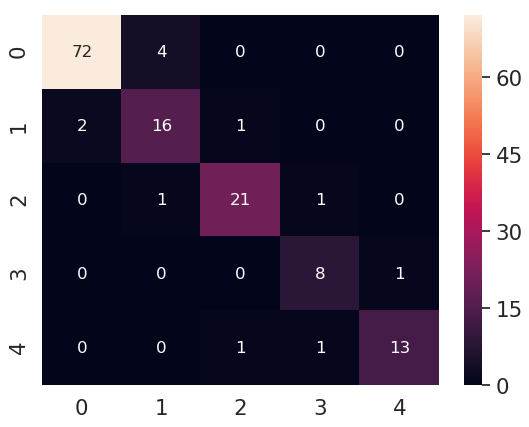

In [41]:
df_cm_test = pd.DataFrame(confusion_matrix_for_testset, range(5), range(5))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm_test, annot=True, annot_kws={"size": 12})# font size

sn.reset_orig()

In [42]:
# generate roc curve
n_classes = 5

# Plot linewidth.
lw = 2

loaded_cross_model = load_model('D:/retinal_data_set_visioncare/models/resnet18/resnet_without_augmentation_scikit_model.h5')

#convert original class labels to the one-hot-encoding
# y_test = np_utils.to_categorical(test_generator.classes, 5)
y_test = np_utils.to_categorical(test_labels, 5)

Y_test_pred = loaded_cross_model.predict(X_test)
Y_test_predicted = np.argmax(Y_test_pred, axis=1)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], Y_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [43]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), Y_test_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [44]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

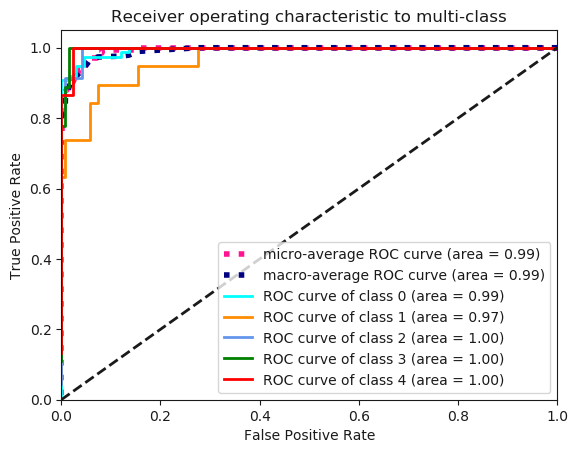

In [45]:
# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

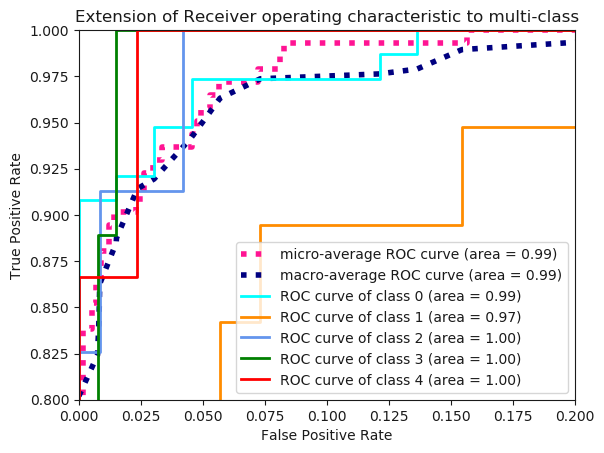

In [46]:
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()